# Partie 2:  Prétraitement d'images 

## 

# Sommaire 

### I- Requirement 

- Création des labels des photos à partir de ses catégories
- Importer les différentes librairies necessaire.
- Installation des bibliotheques necessaire.
- Charger la base de donnée totale.

### II- Analyse des images
- Méthode de transformation d'image(Niveau de gris, Filtrage bruit, Contraste) 
- Extraction des features d’images: SIFT
- Réduction de dimension sur les images encodées et comparer les résultats avec les catégories réelles.
- Création d'une liste de descripteur par image et pour toutes les images
- Création d'un histogramme
- Réduction des dimensions


#

## I- Requirements

### 1.1 Télechargement et option

In [1]:
pip install "numpy<2"

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.2
    Uninstalling numpy-2.2.2:
      Successfully uninstalled numpy-2.2.2
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
pyfume 0.3.4 requires numpy==1.24.4, but you have numpy 1.26.4 which is incompatible.
pyfume 0.3.4 requires pandas==1.5.3, but you have pandas 2.2.3 which is incompatible.
pyfume 0.3.4 requires scipy==1.10.1, but you have scipy 1.15.1 which is incompatible.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
panel 1.1.0 requires markdown-it-py<3, but you have markdown-it-py 3.0.0 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip instal

In [2]:
# pip install --force-reinstall --no-cache-dir scipy pandas seaborn

### 1.2 Importer les différentes librairies necessaire

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os
import cv2
import time

from PIL import Image,ImageEnhance
from sklearn.decomposition import PCA
from scipy.ndimage import median_filter
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn import cluster, metrics

### 1.3 Charger la base de donnée totale

In [4]:
df_path = r"C:\Users\521169\Documents\Openclassrooms\Projet 6\Jeu de donnée\Dataset+projet+prétraitement+textes+images (1)\Flipkart\flipkart_com-ecommerce_sample_1050.csv"
data = pd.read_csv(df_path)
data.head(3)        

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [5]:
df_image = data[["image"]]
df_image.shape

(1050, 1)

### **A - Analyse du fichier csv**

 - **Création des labels des photos à partir de ses catégories**

In [6]:
# Déterminons toutes les catégories 
categories = data["product_category_tree"].apply(lambda x: x.split('>>')[0].strip('["'))
# Créer l'instance de LabelEncoder
le = LabelEncoder()
df_label = pd.DataFrame()
df_label["pictures"] = data["image"]
df_label["picture_label"] = df_label["pictures"].str.replace(r'\.(jpg|png)$','',regex=True)
df_label["true_categorie"] = categories
# le = preprocessing.LabelEncoder()
df_label["label"] = le.fit_transform(df_label["true_categorie"])
df_label

,pictures,picture_label,true_categorie,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,4
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,958f54f4c46b53c8a0a9b8167d9140bc,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,fd6cbcc22efb6b761bd564c28928483c,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,5912e037d12774bb73a2048f35a00009,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,c3edc504d1b4f0ba6224fa53a43a7ad6,Baby Care,0


In [7]:
df_label.shape

(1050, 4)

In [8]:
df_label.groupby("label").count()

,pictures,picture_label,true_categorie
label,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


### B- Analyse du Fichier Image

In [9]:
# path throught image
img_path = r"C:\Users\521169\Documents\Openclassrooms\Projet 6\Jeu de donnée\Dataset+projet+prétraitement+textes+images (1)\Flipkart\Images"

# Listing all files in the directory
file_names = os.listdir(img_path)

# Creation d'un dataframe avec le nom des fichiers
file_names_df = pd.DataFrame(file_names, columns=["Folder_Image"])

file_names_df["image_noExtention"] = file_names_df["Folder_Image"].str.replace(r'\.(jpg|png)$','',regex=True)
file_names_df['image_noCOPIE'] = file_names_df["image_noExtention"].str.replace('- Copie','', regex=False)
file_names_df.head()

,Folder_Image,image_noExtention,image_noCOPIE
0,009099b1f6e1e8f893ec29a7023153c4.jpg,009099b1f6e1e8f893ec29a7023153c4,009099b1f6e1e8f893ec29a7023153c4
1,0096e89cc25a8b96fb9808716406fe94.jpg,0096e89cc25a8b96fb9808716406fe94,0096e89cc25a8b96fb9808716406fe94
2,00cbbc837d340fa163d11e169fbdb952 - Copie.jpg,00cbbc837d340fa163d11e169fbdb952 - Copie,00cbbc837d340fa163d11e169fbdb952
3,00cbbc837d340fa163d11e169fbdb952.jpg,00cbbc837d340fa163d11e169fbdb952,00cbbc837d340fa163d11e169fbdb952
4,00d84a518e0550612fcfcba3b02b6255 - Copie.jpg,00d84a518e0550612fcfcba3b02b6255 - Copie,00d84a518e0550612fcfcba3b02b6255


In [145]:
# lists_photos = [file for file in os.listdir(img_path)]
# print(len(list_photos))

1067


In [10]:
file_names_df.shape

(1067, 3)

### C- Comparaison des deux dataframes csv et dossier image

In [11]:
# liste des fichiers images provenants du dossiers images
folderimage = file_names_df["Folder_Image"].to_list()

In [12]:
# liste des fichiers images provenants du fichier csv
csv_image = df_label["pictures"].to_list()

In [13]:
compare1 = [x for x in folderimage if x not in csv_image]
compare1

['00cbbc837d340fa163d11e169fbdb952 - Copie.jpg',
 '00d84a518e0550612fcfcba3b02b6255 - Copie.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7 - Copie.jpg',
 '00ed03657cedbe4663eff2d7fa702a33 - Copie.jpg',
 '0a3b5fdf77a361c2d7d9b29c259b8c4e - Copie.jpg',
 '0a8a1e9c6659361c0c2b247f8a6471d0 - Copie.jpg',
 '0abfcbe0e17dd50c4cf5fb1d6037d514 - Copie.jpg',
 '0ae859a69c7608d8197c3ba8c37bc6ec - Copie.jpg',
 '0b793c1727ef52285a25dedf8b86626b - Copie.jpg',
 '0b852704f2002f8865a68818ad4951da - Copie.jpg',
 '0b8c4bc35aee94af356cb1fd2dfa0219 - Copie.jpg',
 '0bb0f7b7a3075f4b9459121abe2185fa - Copie.jpg',
 '0bff0eda7a6677dc1acb0477a1f7a121 - Copie.jpg',
 '0c4718ae90f2889b7021a99ee1cc106c - Copie.jpg',
 '0c70a580d96e50966130e2885d8c3505 - Copie.jpg',
 '0ca8e323551dd7107ef57ef7c3e77aee - Copie.jpg',
 '0d02f4703fde00645704e15bba23e77d - Copie.jpg']

In [14]:
len(compare1)

17

### On constate que le dossier contenant des images à un excédant de 17 images, Et toutes ces images sont des copies d'images. En conclusion il sera necessaire de les supprimés.

In [15]:
compare2 = [x for x in csv_image if x not in folderimage]
compare2 

[]

In [16]:
# on suppression des images contenant des copies
file_names_df = file_names_df[~file_names_df["Folder_Image"].isin(compare1)]
folder_picture = file_names_df[["Folder_Image"]]
folder_picture

,Folder_Image
0,009099b1f6e1e8f893ec29a7023153c4.jpg
1,0096e89cc25a8b96fb9808716406fe94.jpg
3,00cbbc837d340fa163d11e169fbdb952.jpg
5,00d84a518e0550612fcfcba3b02b6255.jpg
7,00e966a5049a262cfc72e6bbf68b80e7.jpg
...,...
1062,feefbdff924dd6b7cc266449c9a36d69.jpg
1063,ff24511994fc459d04145231c8876d6c.jpg
1064,ffbf3794aa8cb6bb8d3f313d0a549a09.jpg
1065,ffc2e1fc7c886ec09a331040ada038aa.jpg


In [17]:
df_folder_image = pd.DataFrame(folder_picture)

# Fusion des deux DataFrames pour associer les labels
df_merged = df_folder_image.merge(df_label, how="left", left_on="Folder_Image", right_on="pictures")
df_merged.head()

,Folder_Image,pictures,picture_label,true_categorie,label
0,009099b1f6e1e8f893ec29a7023153c4.jpg,009099b1f6e1e8f893ec29a7023153c4.jpg,009099b1f6e1e8f893ec29a7023153c4,Watches,6
1,0096e89cc25a8b96fb9808716406fe94.jpg,0096e89cc25a8b96fb9808716406fe94.jpg,0096e89cc25a8b96fb9808716406fe94,Kitchen & Dining,5
2,00cbbc837d340fa163d11e169fbdb952.jpg,00cbbc837d340fa163d11e169fbdb952.jpg,00cbbc837d340fa163d11e169fbdb952,Home Furnishing,4
3,00d84a518e0550612fcfcba3b02b6255.jpg,00d84a518e0550612fcfcba3b02b6255.jpg,00d84a518e0550612fcfcba3b02b6255,Beauty and Personal Care,1
4,00e966a5049a262cfc72e6bbf68b80e7.jpg,00e966a5049a262cfc72e6bbf68b80e7.jpg,00e966a5049a262cfc72e6bbf68b80e7,Computers,2


In [18]:
df_data = df_merged
# conversion en une liste
list_photo = df_data["Folder_Image"].to_list()
len(list_photo)

1050

##

## II- Analyse des images: méthode d'extraction d'image

- **Extraction d'une image**

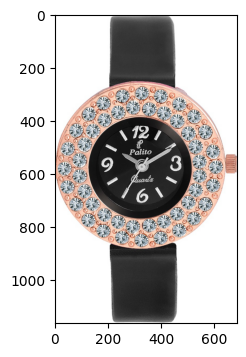

In [19]:
# Filtrage pour garder seulement les fichiers images
data_images = [f for f in list_photo if f.endswith(('.png', '.jpg', '.jpeg'))]

# Création d'une figure pour afficher les images
plt.figure(figsize=(5, 4))  
for index, images in enumerate(data_images[:1]): # charger l premieres images
    chemin_image = os.path.join(img_path, images)# Chemin complet vers l'image
    image_one = Image.open(chemin_image)# Chargement de l'image
    #plt.subplot(len(fichiers_images[2]), 1, index + 1)# Ajoutons de l'image à la figure
    plt.imshow(image_one)
    plt.axis()  
plt.show()

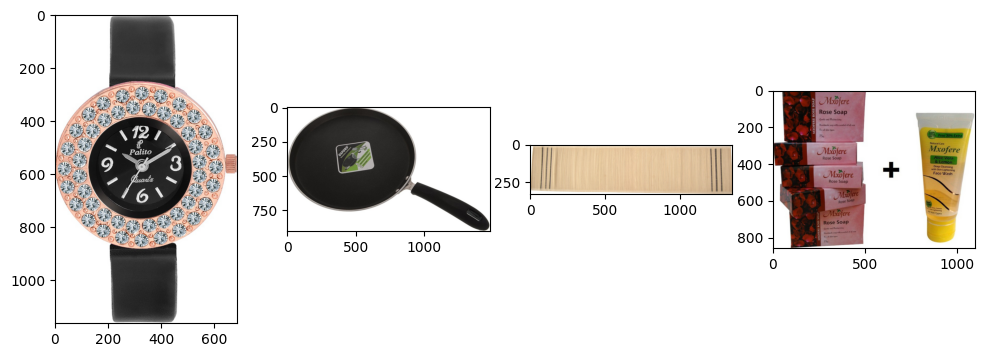

In [20]:
# Création d'une figure pour afficher les images
plt.figure(figsize=(12, 4))  
for index, images in enumerate(data_images[:4]): # charger les 20 premieres images
    chemin_image = os.path.join(img_path, images)# Chemin complet vers l'image
    all_image = Image.open(chemin_image)# Chargement de l'image
    plt.subplot(1,4, index +1)# Ajoutons de l'image à la figure
    plt.imshow(all_image)
    plt.axis()  
plt.show()

- **Extraction de toutes les images**

In [21]:
# Création d'une figure pour afficher les images
for index, images in enumerate(data_images):
    chemin_image = os.path.join(img_path, images)
    all_image = Image.open(chemin_image)
# récupérer les valeurs de tous les pixels sous forme de matrice
matrice = np.array(all_image)
matrice.shape, matrice[:2]

C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


((1077, 1100, 3),
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [254, 254, 254],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [255, 255, 255]]], dtype=uint8))


**2.1** <span style="color: blue;">**Niveau de gris**</span>.

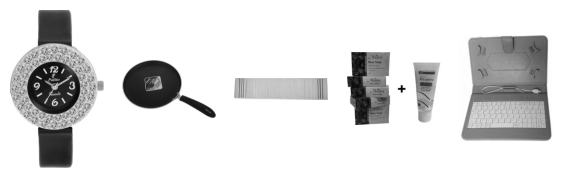

In [22]:
# Niveau de gris
plt.figure(figsize=(7,5))  
for index, images in enumerate(data_images[:5]):
    chemin_image = os.path.join(img_path, images)
    img = Image.open(chemin_image)
    image_gris = img.convert('L') # Conversion les images en niveaux de gris
    # Ajout de l'image à la figure
    plt.subplot(1, 5, index + 1)
    plt.imshow(image_gris, cmap='gray')
    plt.axis("off") 
plt.show()   

In [23]:
for index, images in enumerate(data_images):
    chemin_image = os.path.join(img_path, images)
    img = Image.open(chemin_image)
image_gris = img.convert('L')
Matrice_gris = np.array(image_gris)
Matrice_gris[:2],Matrice_gris.shape

(array([[255, 255, 255, ..., 254, 255, 255],
        [255, 255, 255, ..., 254, 254, 255]], dtype=uint8),
 (1077, 1100))

**2.2**  <span style="color: blue;">**Filtrage du bruit**</span>

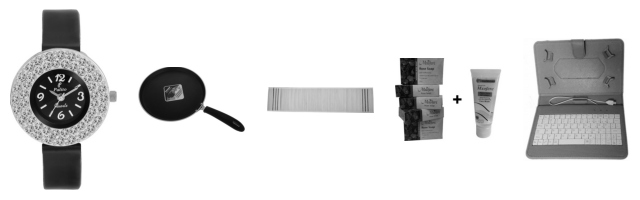

In [24]:
# Création d'une figure pour afficher les images
plt.figure(figsize=(8, 5))  
for index, images in enumerate(data_images[:5]):
    # Chemin complet vers l'image
    chemin_image = os.path.join(img_path, images)

    image = Image.open(chemin_image).convert('L') # Chargement de l'image et conversion en niveaux de gris
    image_np = np.array(image) # Conversion de l'image PIL en tableau numpy pour traitement
    image_filtered = median_filter(image_np, size=3) # Application du filtre médian
    
    # Ajout de l'image filtrée à la figure
    plt.subplot(1, 5 , index + 1)
    plt.imshow(image_filtered, cmap='gray')
    plt.axis('off') 
plt.show()

**2.3** - <span style="color: blue;">**Contraste**</span>

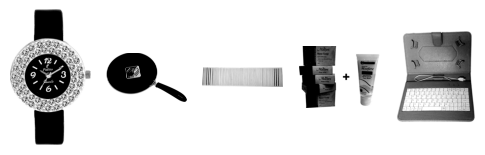

1050

In [25]:
plt.figure(figsize=(6, 5))
# Application d'un contraste 
for index, images in enumerate(data_images[:5]):
    chemin_image = os.path.join(img_path, images)
    image = Image.open(chemin_image).convert('L') 
    
    # Application du filtre médian
    image_np = np.array(image)
    filtered_image = median_filter(image_np, size=3)  # Ajustez la taille si nécessaire
    image_pil = Image.fromarray(filtered_image)
     # Amélioration du contraste
    enhancer = ImageEnhance.Contrast(image_pil)
    contrasted_image = enhancer.enhance(2.0)  # Le facteur 2.0 augmente le contraste; ajustez selon le besoin
    
    # Affichage de l'image avec contraste amélioré
    plt.subplot(1, 5, index + 1)
    plt.imshow(contrasted_image, cmap='gray')
    plt.axis('off')  
plt.show()
len(data_images)

**2.4**- <span style="color: blue;">**Création d'une liste de descripteur par image et pour toutes les images**</span>

- **Descripteur silf pour une image**

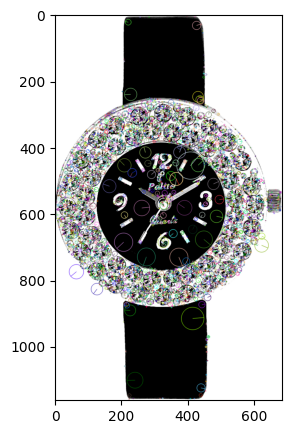

le Nombre de descripteurs pour cette image est : (6020, 128)


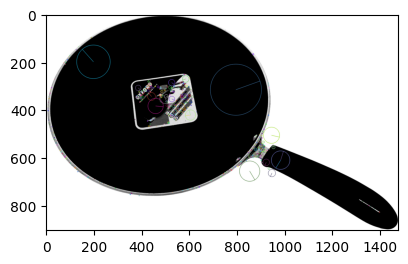

le Nombre de descripteurs pour cette image est : (561, 128)


In [26]:

# """"""**Un descripteur** est un vecteur qui décrit le voisinage de la feature à laquelle il est associé.""""""
# """"""Il est utilisé pour repérer les paires de features qui se ressemblent le plus dans deux images""""""


# Boucle pour charger chaque image, la convertir en niveaux de gris, appliquer le filtre médian et améliorer le contraste
All_descriptors = 0
for index, images in enumerate(data_images[:2]):
    chemin_image = os.path.join(img_path, images)
    image = Image.open(chemin_image).convert('L')
    image_np = np.array(image)
    filtered_image = median_filter(image_np, size=3) 
    image_pil = Image.fromarray(filtered_image)
    enhancer = ImageEnhance.Contrast(image_pil)
    contrasted_image = enhancer.enhance(3.0)
    
    # Conversion en array pour OpenCV
    contrasted_image_np = np.array(contrasted_image)
    # Initialisation de l'objet SIFT
    sift = cv2.SIFT_create()
    # Détection des keypoints et calcul des descripteurs
    keypoints, descriptors = sift.detectAndCompute(contrasted_image_np, None)
    if descriptors is not None:
        All_descriptors += descriptors.shape[0]
    # vecteur correspond
    vector_descriptors = np.asarray(descriptors)
    # concatenation
    descrip_concat = np.concatenate(vector_descriptors, axis= 0)
    
    # Dessiner les keypoints sur l'image
    keypoint_image = cv2.drawKeypoints(contrasted_image_np, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # Conversion de BGR en RGB pour affichage avec matplotlib
    keypoint_image = cv2.cvtColor(keypoint_image, cv2.COLOR_BGR2RGB) 
    
    # Création d'une figure pour afficher les images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2 ,index +1 )
    plt.imshow(keypoint_image,cmap='gray')
    plt.axis()
    
    plt.show()
    print("le Nombre de descripteurs pour cette image est :", vector_descriptors.shape)
    descriptors
# descrip_concat

###  2.5 Nombres de descripteurs total 

In [162]:

# """"""**Un descripteur** est un vecteur qui décrit le voisinage de la feature à laquelle il est associé.""""""
# """"""Il est utilisé pour repérer les paires de features qui se ressemblent le plus dans deux images""""""


# Boucle pour charger chaque image, la convertir en niveaux de gris, appliquer le filtre médian et améliorer le contraste
all_descriptors = 0
list_all_descriptors = [] # liste de tous les descripteurs
time_all_descriptors = time.time()

for index, images in enumerate(data_images):
    chemin_image = os.path.join(img_path, images)
    image = Image.open(chemin_image).convert('L')
    image_np = np.array(image)
    filtered_image = median_filter(image_np, size=3) 
    image_pil = Image.fromarray(filtered_image)
    enhancer = ImageEnhance.Contrast(image_pil)
    contrasted_image = enhancer.enhance(2.0)
    
    # Conversion en array pour OpenCV
    contrasted_image_np = np.array(contrasted_image)
    # Initialisation de l'objet SIFT
    sift = cv2.SIFT_create(1000)
    # Détection des keypoints et calcul des descripteurs
    keypoints, descriptors = sift.detectAndCompute(contrasted_image_np, None)
    if descriptors is not None:
       all_descriptors += descriptors.shape[0]
       list_all_descriptors.append(descriptors)
        
print("le Nombre de descripteurs pour toutes les images est :", all_descriptors)
duration_descrip = time.time()-time_all_descriptors
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration_descrip, "secondes")

le Nombre de descripteurs pour toutes les images est : 896236
temps de traitement SIFT descriptor :           585.31 secondes


In [153]:
# Concaténation de tous les descripteurs dans un seul tableau numpy
Total_descriptors = np.vstack(list_all_descriptors)
Total_descriptors.shape
sift_keypoints_img = np.concatenate(Total_descriptors, axis=0)
sift_keypoints_img,Total_descriptors.shape

(array([4., 6., 4., ..., 0., 0., 0.], dtype=float32), (896236, 128))

## III- Création des clusters des descripteurs

- **Clustering** 
- Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [29]:
# Début de la mesure du temps
time_clusters = time.time()

# calculons le nombre de cluster
k = int(round(np.sqrt(all_descriptors)))
print("Nombre de clusters estimés:", k )
print("Création de",k,"clusters de descripteurs")

# Clustering des descripteurs avec MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=k*3, random_state = 0)
model_clusters = kmeans.fit(Total_descriptors) #

# Fin de la mesure du temps
end_time = time.time()
duration_clusters = end_time - time_clusters
print("Temps de traitement kmeans:", "{:.2f} secondes".format(duration_clusters))

Nombre de clusters estimés: 947
Création de 947 clusters de descripteurs
Temps de traitement kmeans: 28.52 secondes


## **Création d'un histogramme par image**

* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

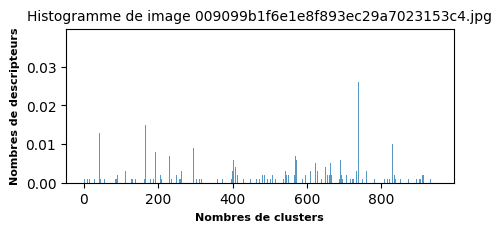

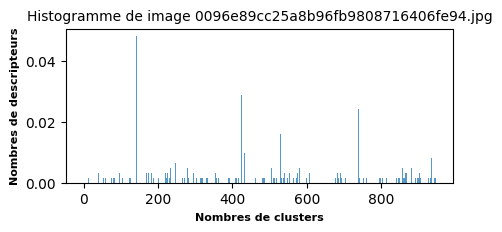

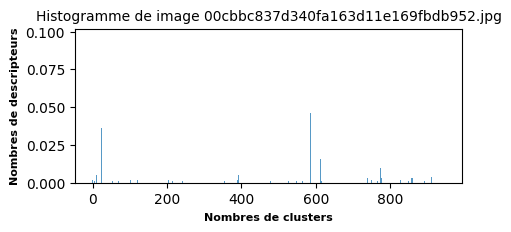

In [70]:
num_clusters = 947
temps3 = time.time()

def build_histogram(kmeans, descriptors, images):
    res = kmeans.predict(descriptors)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(descriptors)
    if nb_des==0 : 
        print("problème histogramme image: ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

# Creation of a matrix of histograms
hist_vectors=[]

for i, descript in enumerate(list_all_descriptors[:3]) : # [:3]
#     if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, descript, i) #calculate de histogramme
    hist_vectors.append(hist) #histogramme des vecteurs de features
    
    # Affichage de l'histogramme  plt.subplot(1, 5, index + 1)
    plt.figure(figsize=(5,2))
    plt.bar(range(num_clusters), hist, alpha=0.75)
    plt.title(f'Histogramme de image {data_images[i]}', size = 10)
    plt.xlabel('Nombres de clusters', size = 8, fontweight = 'bold')
    plt.ylabel('Nombres de descripteurs', size = 8, fontweight = 'bold')
    plt.show()

In [164]:
num_clusters = 947
temps3 = time.time()

def build_histogram(kmeans, descriptors, image_num):
    res = kmeans.predict(descriptors)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(descriptors)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(list_all_descriptors) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)
duration3 = time.time() - temps3
print("temps de création histogrammes : ", "%15.2f" % duration3, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             5.06 secondes


In [165]:
len(im_features)

1049

In [124]:
len(data_images)

1050

## **Réductions de dimension**

#### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [166]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components= 0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1049, 947)
Dimensions dataset après réduction PCA :  (1049, 539)


In [129]:
rapport_de_reduction = round(947/539,2)
rapport_de_reduction

1.76

#### **Réduction de dimension T-SNE**
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [167]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1','tsne2'])
df_tsne["category"] = df_data["true_categorie"]

C:\Users\521169\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


- **Visualisation des composantes T_SNE**

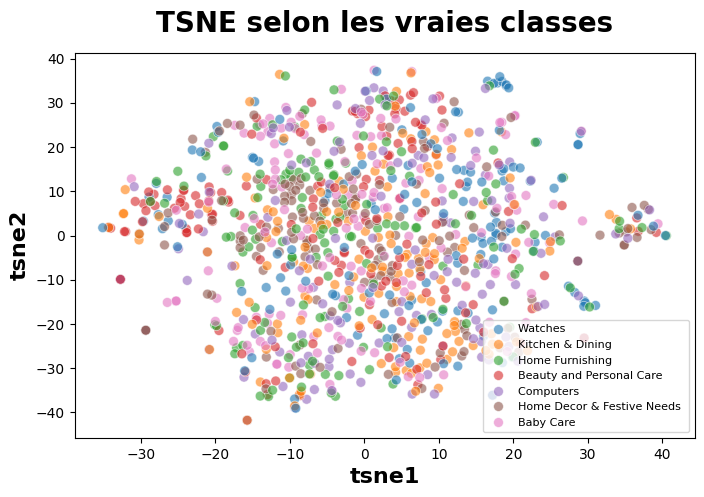

In [168]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="category", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 20, pad = 15, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 16, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 16, fontweight = 'bold')
plt.legend(prop={'size': 8}) 

plt.show()

### **Analyse mesures : similarité entre catégories et clusters**

-  **Création de clusters à partir du T-SNE**

In [170]:
# Création des clusters
cls = cluster.KMeans(n_clusters=7 ,random_state=6)
cls.fit(X_tsne)
df_tsne["cluster"] = cls.labels_
df_tsne.shape

(1049, 4)

In [171]:
cluster_labels = cls.labels_
cluster_labels

array([3, 5, 2, ..., 5, 1, 2])

###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
- Visualisation

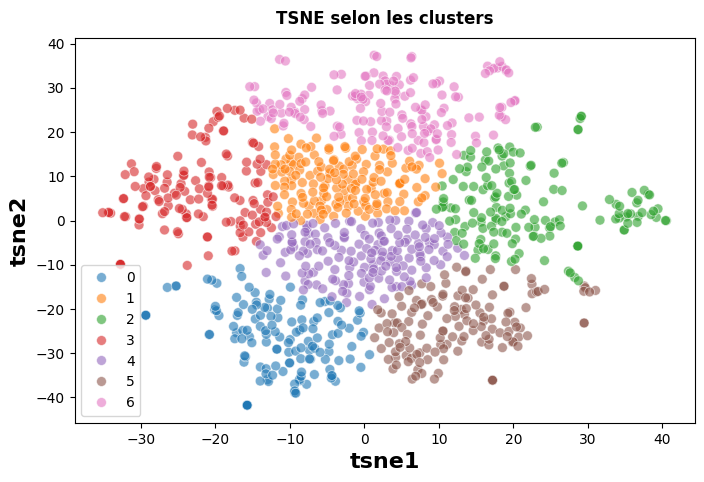

In [172]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")
plt.title('TSNE selon les clusters', fontsize = 12, pad = 10, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 16, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 16, fontweight = 'bold')
plt.legend(prop={'size': 10}) 

plt.show()

In [136]:
labels_ = df_data["label"].head(1049)

- **Score**

In [137]:
print("ARI:", metrics.adjusted_rand_score(labels_, cluster_labels))

ARI: 0.023915567104160373


 - #### Analyse par classes

In [138]:
df_tsne.groupby("cluster").count()["category"]

cluster
0    138
1    154
2    155
3    143
4    157
5    139
6    163
Name: category, dtype: int64

- **Calcul de la matrice de confusion**

In [139]:
conf_mat = metrics.confusion_matrix(labels_, cluster_labels)
print(conf_mat)

[[29 31 18 11 17 10 34]
 [12 16 11 41 22 16 32]
 [32  5 27 14 15 29 27]
 [12 38 23 21 29 16 11]
 [29 33 21 22 19 11 15]
 [17 18 12 16 35 32 20]
 [ 7 13 43 18 20 25 24]]


In [140]:
df_tsne["category"].value_counts()

category
Watches                        150
Kitchen & Dining               150
Home Furnishing                150
Beauty and Personal Care       150
Home Decor & Festive Needs     150
Baby Care                      150
Computers                      149
Name: count, dtype: int64

In [141]:
from sklearn.metrics import classification_report

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [6, 5, 4, 3, 2, 1, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels_, cluster_labels)
conf_mat = metrics.confusion_matrix(labels_, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels_, cls_labels_transform))

Correspondance des clusters :  [6, 5, 4, 3, 2, 1, 0]
[[34 10 17 11 18 31 29]
 [32 16 22 41 11 16 12]
 [27 29 15 14 27  5 32]
 [11 16 29 21 23 38 12]
 [15 11 19 22 21 33 29]
 [20 32 35 16 12 18 17]
 [24 25 20 18 43 13  7]]

              precision    recall  f1-score   support

           0       0.21      0.23      0.22       150
           1       0.12      0.11      0.11       150
           2       0.10      0.10      0.10       149
           3       0.15      0.14      0.14       150
           4       0.14      0.14      0.14       150
           5       0.12      0.12      0.12       150
           6       0.05      0.05      0.05       150

    accuracy                           0.13      1049
   macro avg       0.12      0.13      0.12      1049
weighted avg       0.12      0.13      0.12      1049



In [142]:
list_category = df_data['true_categorie'].to_list()
liste_unique = list(set(list_category))
liste_unique

['Beauty and Personal Care ',
 'Home Decor & Festive Needs ',
 'Computers ',
 'Home Furnishing ',
 'Watches ',
 'Baby Care ',
 'Kitchen & Dining ']

### Tableaux de contingence

<Axes: >

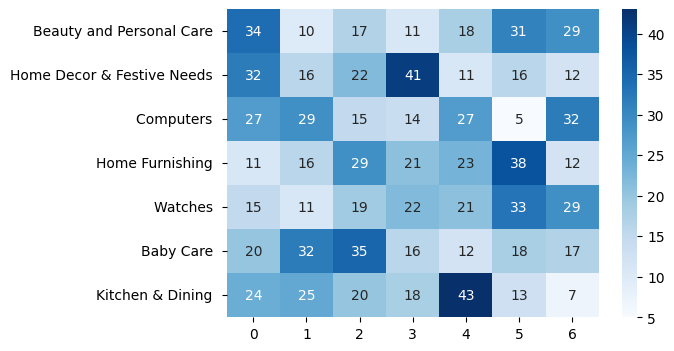

In [143]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_unique],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

Le tableau de contingence nous montre que la méthode de cluster </br>
n'est pas satisfaisante, car elle ne parvient pas à bien regrouper les images </br>
en fonctions de leurs catégories. 

### Dans le **notebook3** nous analyserons ce même cas de figure avec un modèle pré entrainé.